#### **RL Trading agent**
Used a leading financial institution: https://www.gtcoplc.com/ historical stock price history for this environment

In [1]:
import gymnasium
from gymnasium import spaces
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
class NGXTrading(gymnasium.Env): # To implement the Nigeria Exchange Limited(NGX) trading environment for GTCO shares
      def __init__(self, sp_history, train=True, days=30):
          # sp_history = stock price history,
          # days = period the agent studies the stock price trend to guide its decision
         self.sp_history = sp_history
         self.data = pd.read_csv(self.sp_history)
         self.train = train

         # Set up train and test dataset
         self.training_data = self.data.iloc[:int(0.75 * len(self.data))]
         self.testing_data = self.data.iloc[int(0.75 * len(self.data)):].reset_index()

         self.observation_space = spaces.Discrete(4)
         self.action_space = spaces.Discrete(3) # agent discrete action -> BUY | HOLD | SELL

         self.capital = 1000000 # capital invested by the agent(prototype trading, it is best off to start small)
         self.shares = 0 # quantity of shares owned by the agent
         self.stock_value = 0 # value of the shares currently invested by the agent
         self.buying_price = 0 # total value of the shares bought by the agent

         self.investment = self.capital + self.stock_value # this sums the agent total investment
         self.investment_list = [] # an empty list to store the invested amount over train and test loop
         self.days = days

         if self.train:
            self.max_timesteps = len(self.training_data) - self.days # agent timesteps to guide the env episodes before each ends
         else:
            self.max_timesteps = len(self.testing_data) - self.days

         self.timestep = 0
         self.reset()

      def reset(self):
          self.capital = 1000000
          self.shares = 0
          self.stock_value = 0
          self.buying_price = 0
          self.investment = self.capital + self.stock_value
          self.investment_list = []
          self.timestep = 0 # as always, agent steps initializes to 0

          if self.train:
             self.max_timesteps = len(self.training_data) - self.days # this allows the agent to train within this period maximizing its timestep

             # stock price direction --> increase / decrease /stays same
             change_direction = []
             for a in range(self.days):
                 if self.training_data['Close'][self.timestep + 1 + a] - self.training_data['Close'][self.timestep + a] > 0:
                    change_direction.append(1)
                 else:
                    change_direction.append(0)

             if (np.sum(change_direction) / self.days) >= 0.5:
                 change = True
             else:
                 change = False

             stock_held = False

             observation = [change, stock_held]

          else:
             self.max_timesteps = len(self.testing_data) - self.days

             change_direction = []
             for a in range(self.days):
                 if self.testing_data['Close'][self.timestep + 1 + a] - self.testing_data['Close'][self.timestep + a] > 0:
                    change_direction.append(1)
                 else:
                    change_direction.append(0)

             if (np.sum(change_direction) / self.days) >= 0.5:
                 change = True
             else:
                 change = False

             stock_held = False

             observation = [change, stock_held]

          if np.array_equal(observation, [True, False]):
             observation = 0
          if np.array_equal(observation, [True, True]):
             observation = 1
          if np.array_equal(observation, [False, False]):
             observation = 2
          if np.array_equal(observation, [False, True]):
             observation = 3

          info = None
          return observation, info

      def step(self, action):
          reward = 0
          penalty = 0
          # the discrete actions of the agent are broken down --> BUY, SELL, HOLD = 0, 1, 2
          if self.train:
             if action == 0:  # buy
                if self.shares > 0:
                   penalty = -100
                buy_shares = math.floor(self.capital / self.training_data['Open'][self.timestep + self.days])
                self.shares += buy_shares

                if buy_shares > 0:
                   self.stock_value += self.training_data['Open'][self.timestep + self.days] * buy_shares
                   self.buying_price += self.training_data['Open'][self.timestep + self.days] * buy_shares
                   self.capital -= self.training_data['Open'][self.timestep + self.days] * buy_shares
                   reward = 1 + penalty

                else:
                   self.stock_value = self.training_data['Open'][self.timestep + self.days] * self.shares
                   reward = -50

             if action == 1: # sell
                self.capital += self.training_data['Open'][self.timestep + self.days] * self.shares
                sell_value = self.training_data['Open'][self.timestep + self.days] * self.shares

                if self.buying_price > 0:
                   reward = (sell_value - self.buying_price) / self.buying_price * 100
                else:
                   reward = -50

                self.shares = 0
                self.stock_value = 0
                self.buying_price = 0

             if action == 2: # hold
                self.stock_value = self.training_data['Open'][self.timestep + self.days] * self.shares

                if self.buying_price > 0:
                   reward = (self.stock_value - self.buying_price) / self.buying_price * 100
                else:
                   reward = -50

          else:
             if action == 0: # buy for test loop
                if self.shares > 0:
                   penalty = -50
                buy_shares = math.floor(self.capital / self.testing_data['Open'][self.timestep + self.days])
                self.shares += buy_shares

                if buy_shares > 0:
                   self.stock_value += self.testing_data['Open'][self.timestep + self.days] * buy_shares
                   self.buying_price += self.testing_data['Open'][self.timestep + self.days] * buy_shares
                   self.capital -= self.testing_data['Open'][self.timestep + self.days] * buy_shares

                   reward = 1 + penalty
                else:
                   self.stock_value = self.training_data['Open'][self.timestep + self.days] * self.shares
                   reward = -50

             if action == 1: # sell
                self.capital += self.testing_data['Open'][self.timestep + self.days] * self.shares
                sell_value = self.training_data['Open'][self.timestep + self.days] * self.shares

                if self.buying_price > 0:
                   reward = (sell_value - self.buying_price) / self.buying_price * 100
                else:
                   reward = -50

                self.shares = 0
                self.stock_value = 0
                self.buying_price = 0

             if action == 2: # hold
                self.stock_value = self.testing_data['Open'][self.timestep + self.days] * self.shares

                if self.buying_price > 0:
                   reward = (self.stock_value - self.buying_price) / self.buying_price * 100
                else:
                   reward = -5

          if self.shares > 0:
             stock_held = True
          else:
             stock_held = False

          if self.train:
             self.max_timesteps = len(self.training_data) - self.days

             change_direction =[]
             for a in range(self.days):
                 if self.training_data['Close'][self.timestep + 1 + a] - self.training_data['Close'][self.timestep + a] > 0:
                    change_direction.append(1)
                 else:
                    change_direction.append(0)

             if (np.sum(change_direction) / self.days) >= 0.5:
                 change = True
             else:
                 change = False

             observation = [change, stock_held]

          else:
             change_direction =[]
             for a in range(self.days):
                 if self.testing_data['Close'][self.timestep + 1+ a] - self.testing_data['Close'][self.timestep + a] > 0:
                    change_direction.append(1)
                 else:
                    change_direction.append(0)

             if (np.sum(change_direction) / self.days) >= 0.5:
                 change = True
             else:
                 change = False
             observation = [change, stock_held]

          self.timestep += 1

          if np.array_equal(observation, [True, False]):
             observation = 0
          if np.array_equal(observation, [True, True]):
             observation = 1
          if np.array_equal(observation, [False, False]):
             observation = 2
          if np.array_equal(observation, [False, True]):
             observation = 3

          self.investment = self.capital + self.stock_value

          self.investment_list.append(self.investment)

          terminated = True if (self.timestep >= self.max_timesteps) else False
          truncated = False
          info = {}
          return observation, reward, terminated, truncated, info

      def render(self, mode='human'):
          plt.figure(figsize=(10, 5))
          plt.plot(self.investment_list, color='orange', linewidth=4)
          plt.xlabel('Days', fontsize=10)
          plt.ylabel('Investment Value', fontsize=10)
          plt.title('Investment Value Performance', fontsize=10)
          plt.grid()
          plt.show()

In [3]:
# instantiate the env and action as defined above
gtco_env = NGXTrading(sp_history='/content/gtco.csv', train=True, days=30)
gtco_state = gtco_env.observation_space.n
gtco_action = gtco_env.action_space.n
gtco_state, gtco_reward, gtco_terminate, gtco_truncate, info = gtco_env.step(gtco_action)

In [5]:
class stock_agent():
      def __init__(self, state, action,
                   alpha, discount_factor,
                   epsilon_min, epsilon_max, epsilon_decay):
         self.state = state
         self.action = action
         self.alpha = alpha
         self.discount_factor = discount_factor
         self.epsilon_min = epsilon_min
         self.epsilon_max = epsilon_max
         self.epsilon_decay = epsilon_decay

         # initialize the Q_table
         self.Q_table = np.zeros((4, 3))

      def agent_action(self, state):
          agent_explore = np.random.rand() < self.epsilon_max
          if agent_explore:
             action = np.random.randint(0, self.action)
          else:
             action = np.argmax((self.Q_table[state]))
          return action

      def agent_learn(self, state, action, reward, next_state, complete):
          if complete:
             total_value = reward
          else:
             total_value = reward + self.discount_factor * np.max(self.Q_table[next_state])

          Q_entries = self.Q_table[state, action]
          self.Q_table[state, action] += self.alpha * (total_value - Q_entries)

      def eps_decay(self):
          self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)

def train_agent(env, agent, episodes):
    episode_rewards = []
    for episode in range(episodes):
        state,info = env.reset()
        total_reward = 0
        terminate, truncate = False, False

        while not (terminate or truncate):
              action = agent.agent_action(state)
              next_state, reward, terminate, truncate, info = env.step(action)
              agent.agent_learn(state, action, reward, next_state, terminate or truncate)
              total_reward += reward
              state = next_state

        agent.eps_decay()
        episode_rewards.append(total_reward)

        if (episode + 1) % 20 == 0: # batching for every 20 episodes
            print(f'Train Episode {episode+1}/{episodes} | Epsilon: {agent.epsilon_max:.2f} | Train Reward: {total_reward:.2f}')

    return episode_rewards

def test_agent(env, agent, episodes):
    returns = []
    rois = []
    all_investment_list = []
    for episode in range(episodes):
        state,info = env.reset()
        # to ensure variance for the greedy action by the agent, we randomize the start date per episode
        env.timestep = np.random.randint(0, env.max_timesteps - 1)
        terminate, truncate = False, False
        total_reward = 0

        while not (terminate or truncate):
              state_ind = int(state)
              action = np.argmax(agent.Q_table[state_ind])
              next_state, reward, terminate, truncate, info = env.step(action)
              total_reward += reward
              state = next_state

        # agent performance as a % on ROI
        initial_cap = env.investment_list[0]
        close_cap = env.investment_list[-1]
        roi = ((close_cap - initial_cap) / initial_cap) * 100

        returns.append(total_reward)
        rois.append(roi)


        env.render()

        print(f"Test Episode {episode+1}: Test Reward = {total_reward:.2f}: ROI = {roi:.2f}%")

    return returns, rois

In [9]:
# parameters
alpha = 0.10
discount_factor = 0.95
epsilon_min = 0.05
epsilon_max = 1.0
epsilon_decay = 0.99
episodes = 500

gtco_agent = stock_agent(gtco_state, gtco_action, alpha, discount_factor, epsilon_min, epsilon_max, epsilon_decay)

rewards = train_agent(gtco_env, gtco_agent, episodes=500)

Train Episode 20/500 | Epsilon: 0.82 | Train Reward: -3395.24
Train Episode 40/500 | Epsilon: 0.67 | Train Reward: -3111.32
Train Episode 60/500 | Epsilon: 0.55 | Train Reward: -2769.22
Train Episode 80/500 | Epsilon: 0.45 | Train Reward: -1849.44
Train Episode 100/500 | Epsilon: 0.37 | Train Reward: -1723.10
Train Episode 120/500 | Epsilon: 0.30 | Train Reward: -1313.52
Train Episode 140/500 | Epsilon: 0.24 | Train Reward: -1381.27
Train Episode 160/500 | Epsilon: 0.20 | Train Reward: -629.19
Train Episode 180/500 | Epsilon: 0.16 | Train Reward: -573.80
Train Episode 200/500 | Epsilon: 0.13 | Train Reward: -391.03
Train Episode 220/500 | Epsilon: 0.11 | Train Reward: -591.55
Train Episode 240/500 | Epsilon: 0.09 | Train Reward: -192.76
Train Episode 260/500 | Epsilon: 0.07 | Train Reward: -235.37
Train Episode 280/500 | Epsilon: 0.06 | Train Reward: -222.99
Train Episode 300/500 | Epsilon: 0.05 | Train Reward: -145.83
Train Episode 320/500 | Epsilon: 0.05 | Train Reward: 62.25
Train E

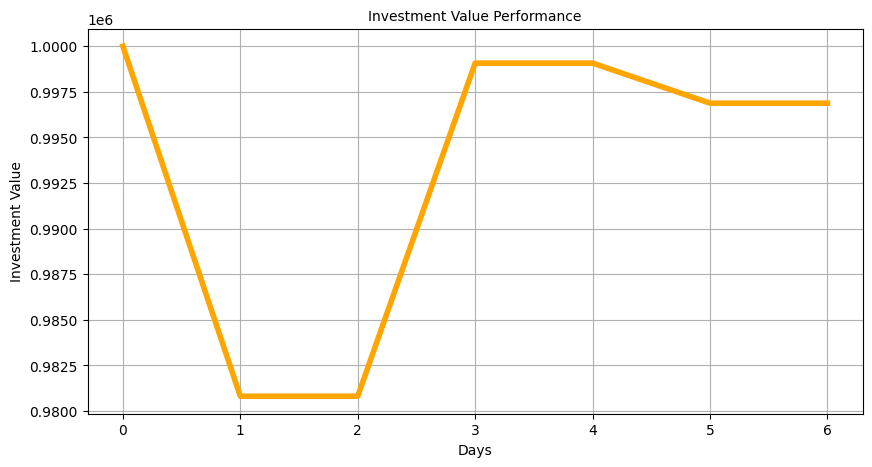

Test Episode 1: Test Reward = 268.10: ROI = -0.31%


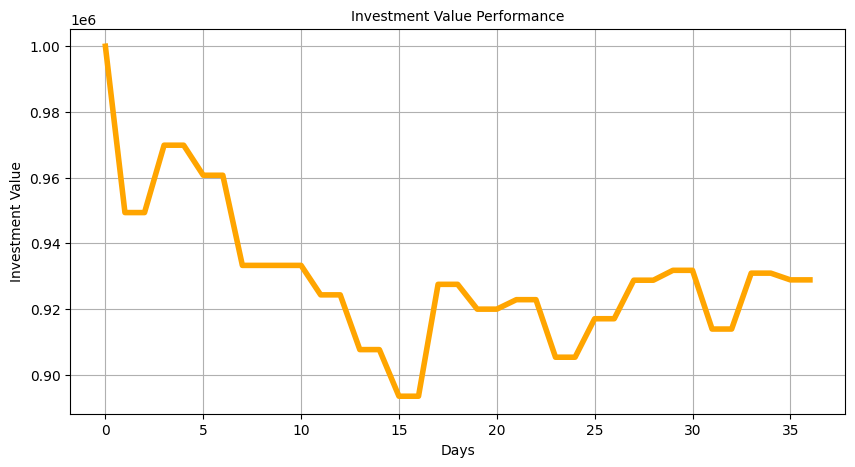

Test Episode 2: Test Reward = 1722.39: ROI = -7.11%


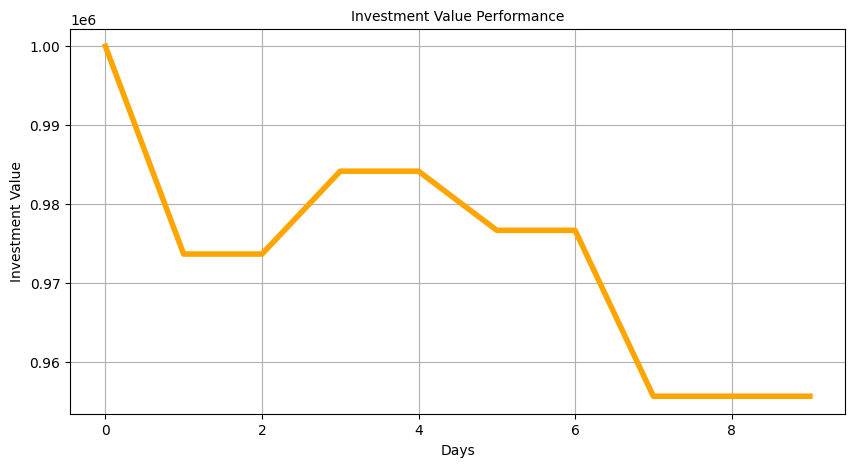

Test Episode 3: Test Reward = 478.04: ROI = -4.43%


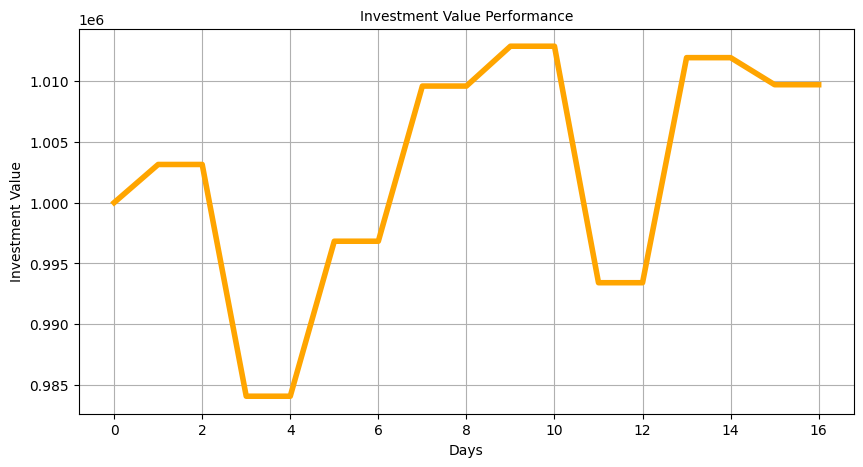

Test Episode 4: Test Reward = 779.87: ROI = 0.97%


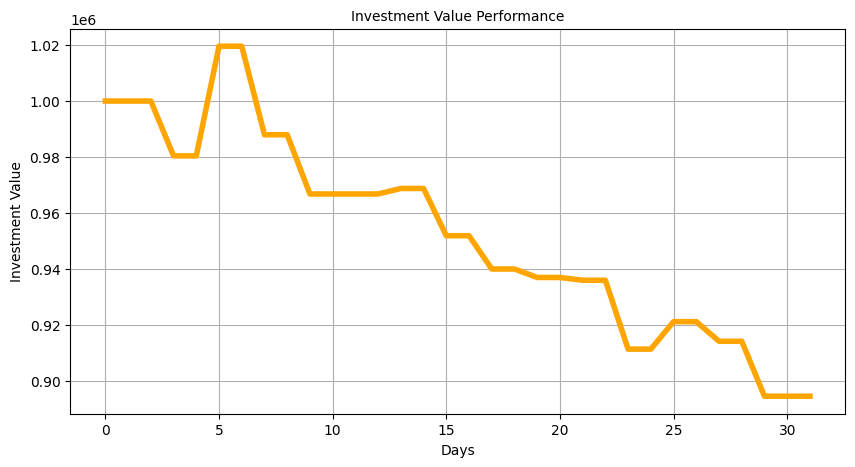

Test Episode 5: Test Reward = 1574.93: ROI = -10.56%


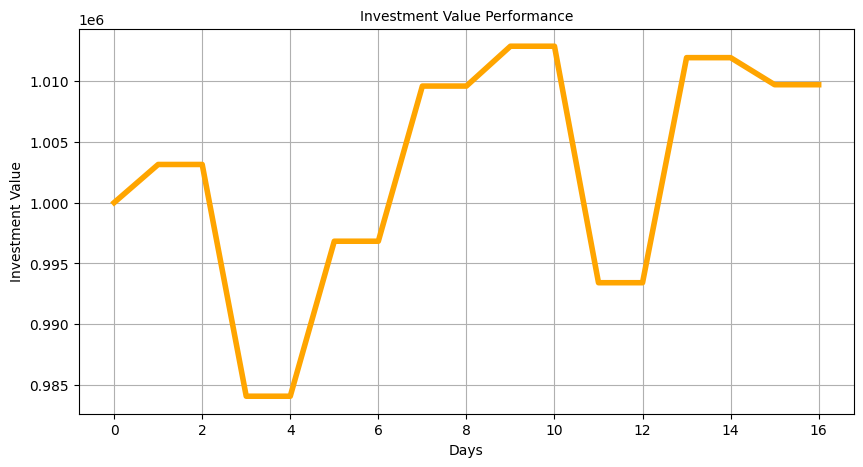

Test Episode 6: Test Reward = 779.87: ROI = 0.97%


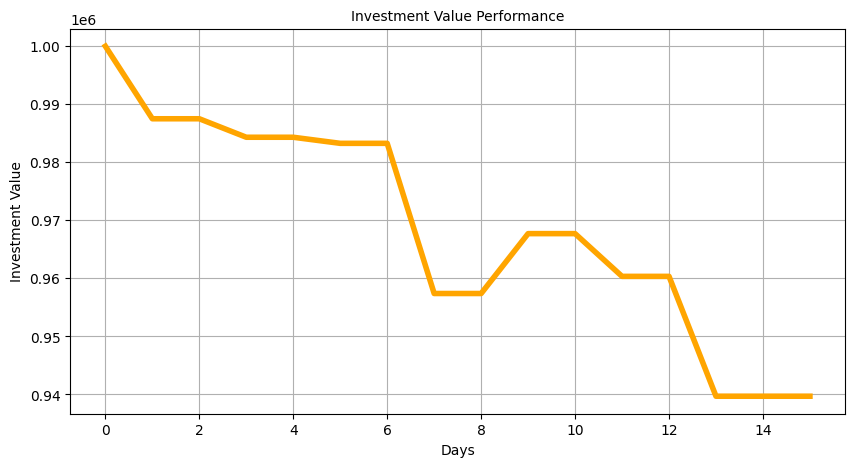

Test Episode 7: Test Reward = 781.25: ROI = -6.03%


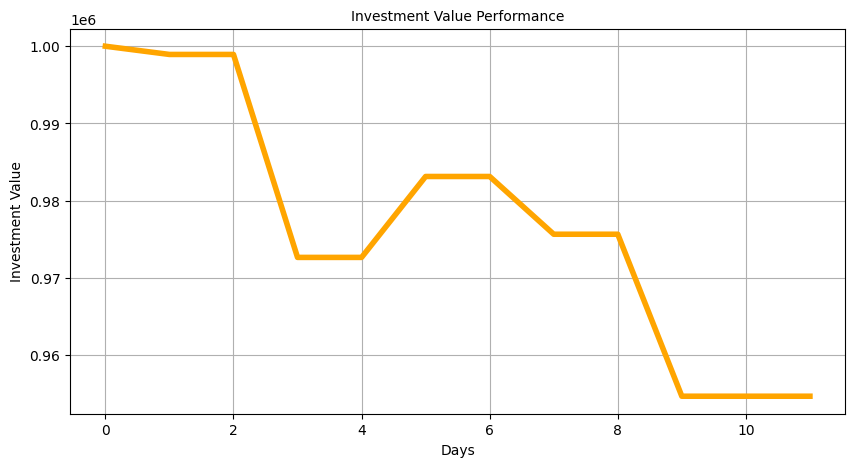

Test Episode 8: Test Reward = 581.49: ROI = -4.53%


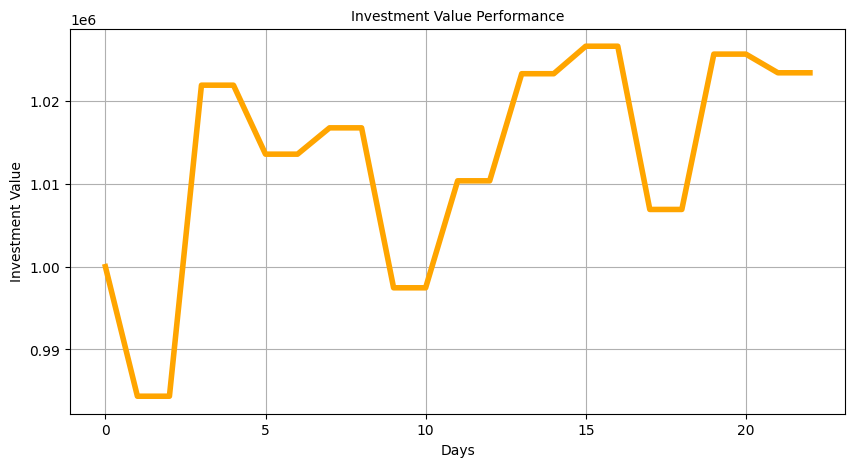

Test Episode 9: Test Reward = 1104.25: ROI = 2.34%


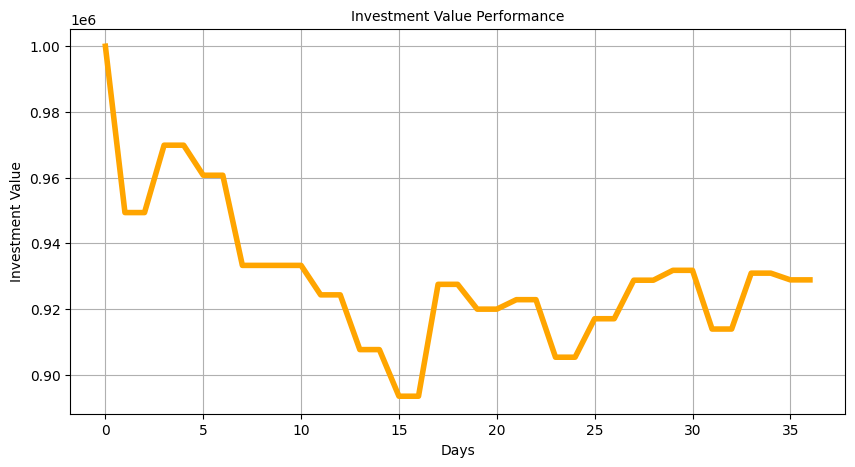

Test Episode 10: Test Reward = 1722.39: ROI = -7.11%


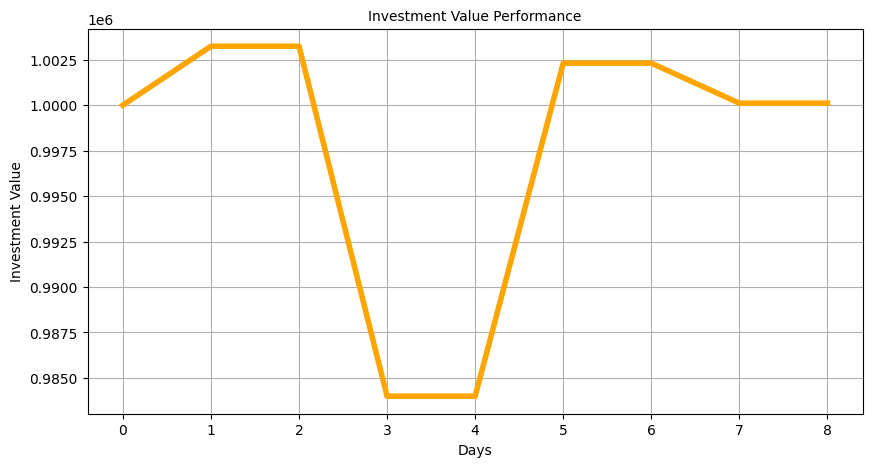

Test Episode 11: Test Reward = 378.83: ROI = 0.01%


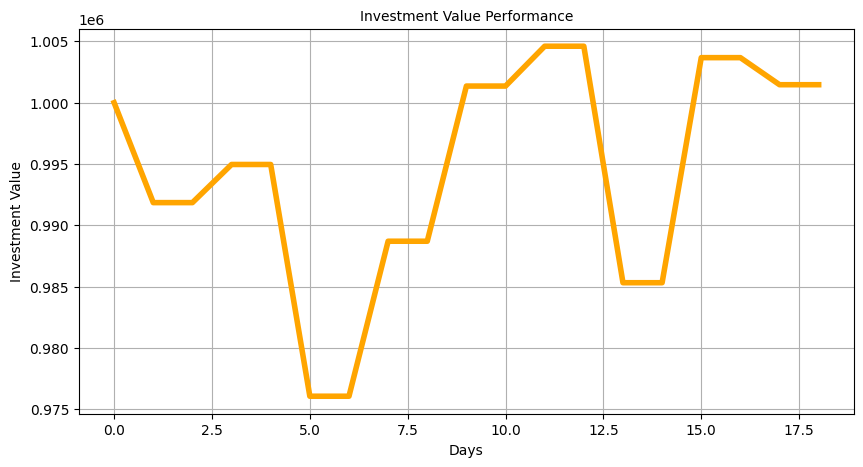

Test Episode 12: Test Reward = 880.77: ROI = 0.15%


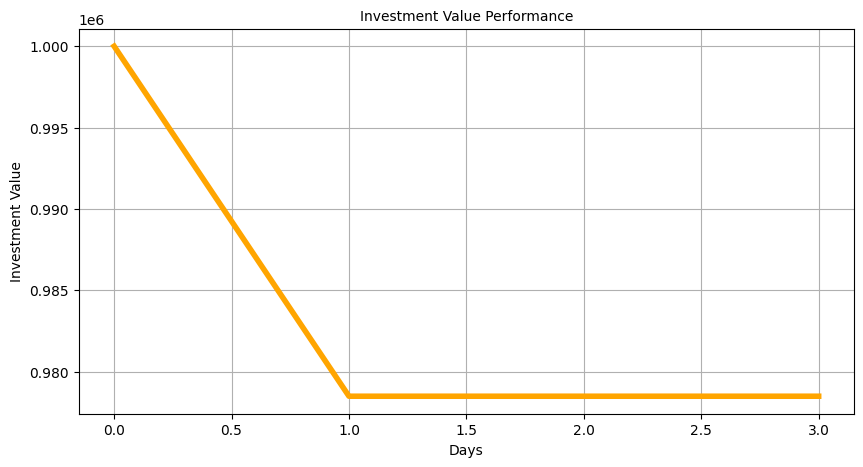

Test Episode 13: Test Reward = 165.99: ROI = -2.15%


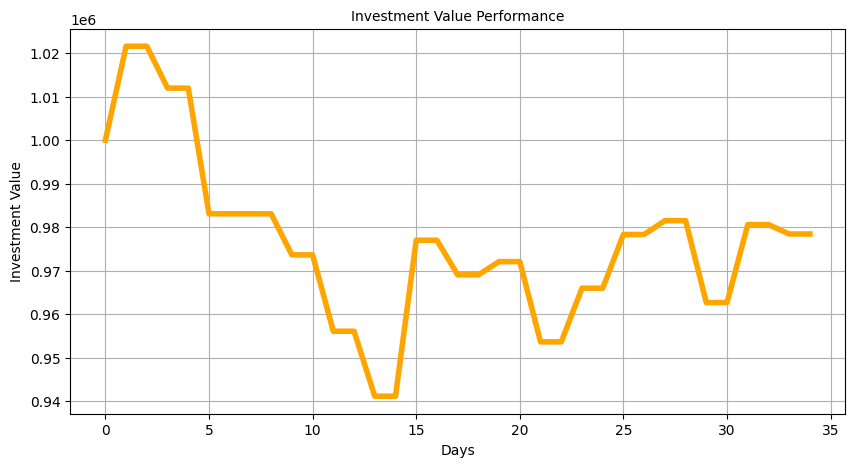

Test Episode 14: Test Reward = 1645.03: ROI = -2.16%


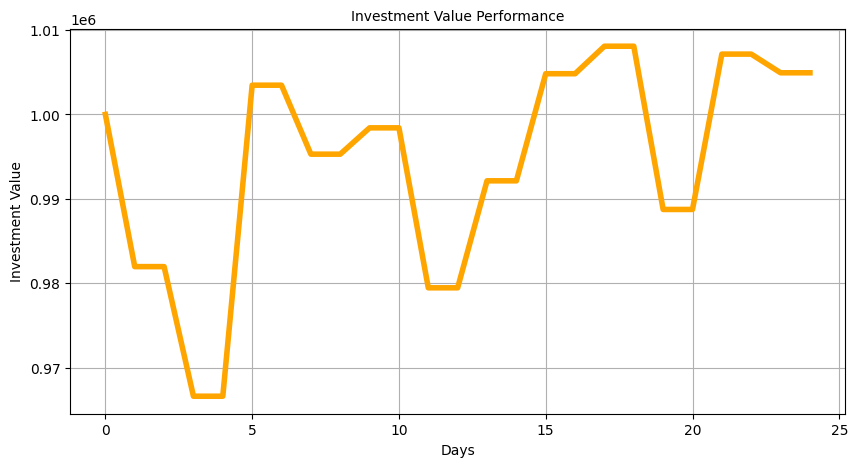

Test Episode 15: Test Reward = 1204.45: ROI = 0.49%


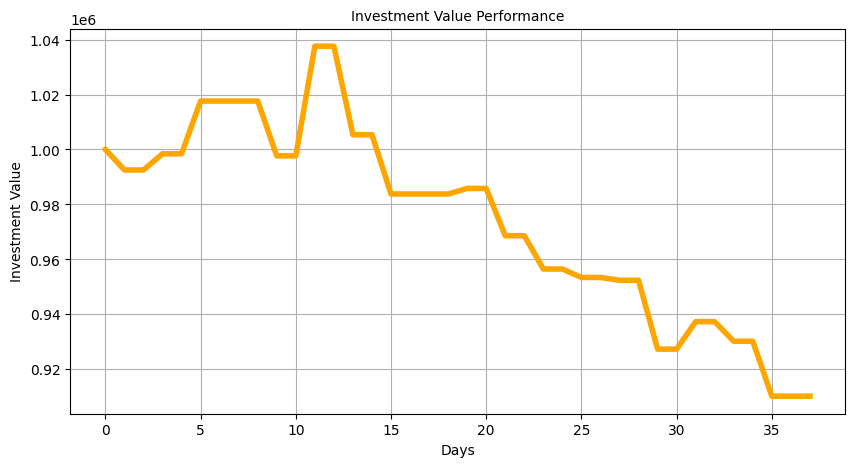

Test Episode 16: Test Reward = 1822.79: ROI = -8.98%


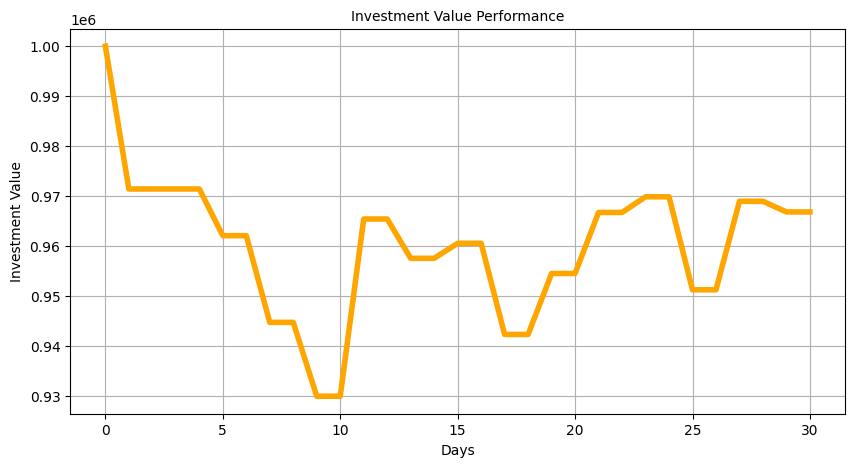

Test Episode 17: Test Reward = 1482.90: ROI = -3.32%


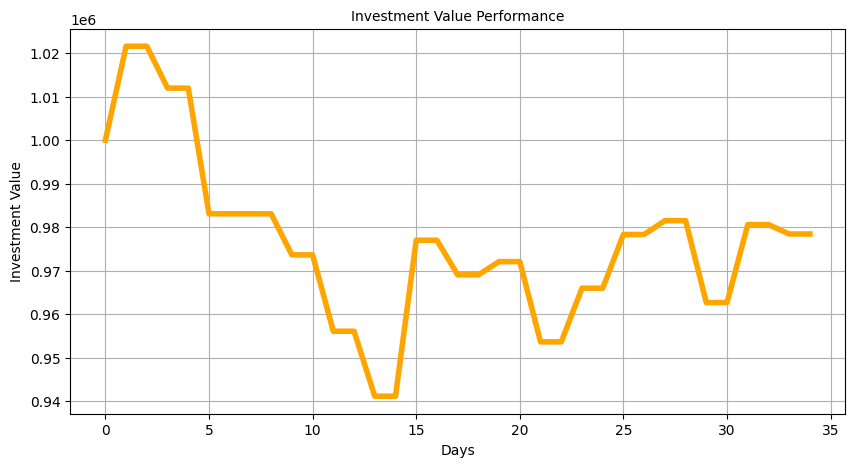

Test Episode 18: Test Reward = 1645.03: ROI = -2.16%


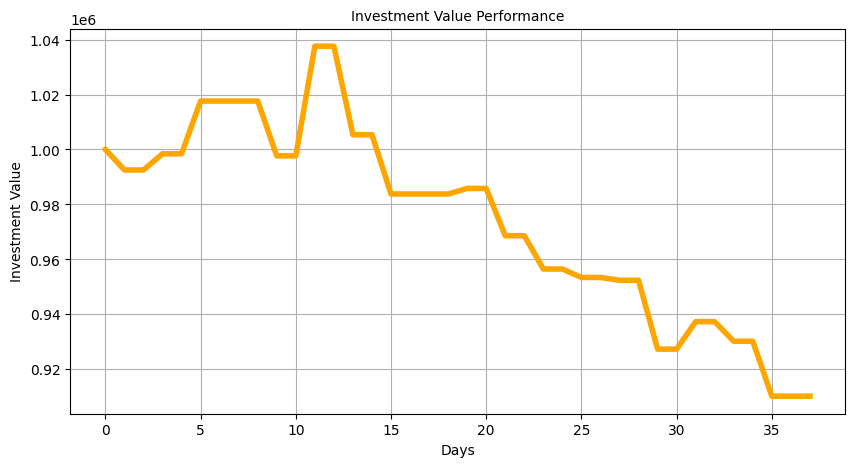

Test Episode 19: Test Reward = 1822.79: ROI = -8.98%


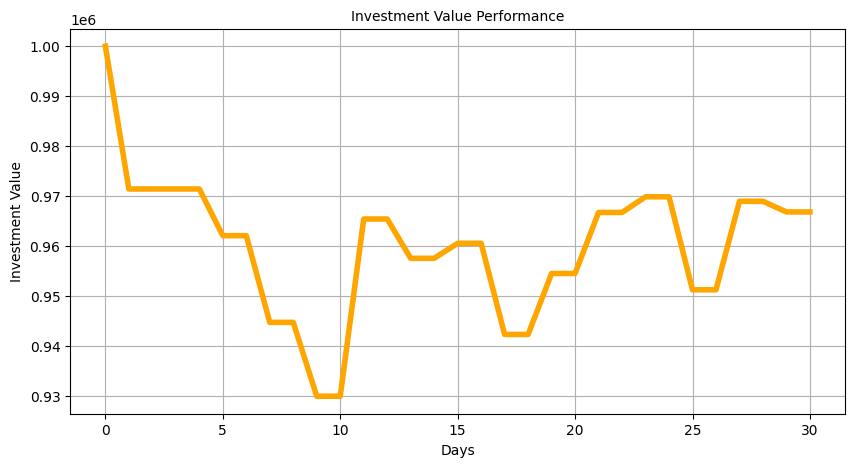

Test Episode 20: Test Reward = 1482.90: ROI = -3.32%


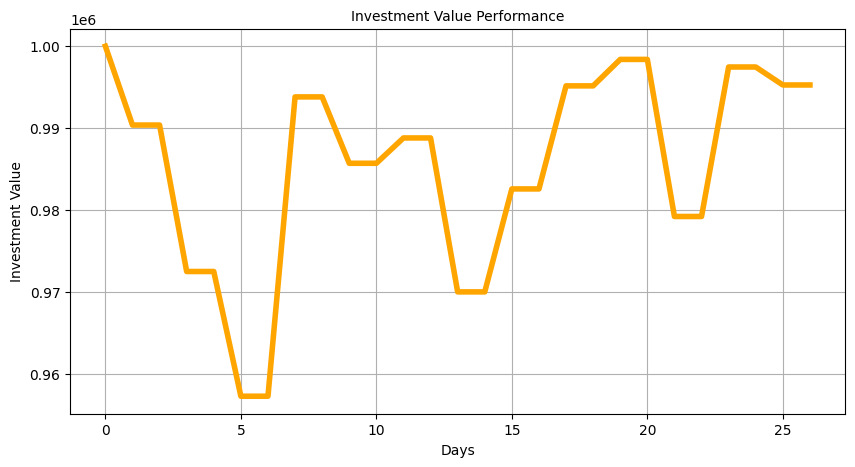

Test Episode 21: Test Reward = 1297.75: ROI = -0.47%


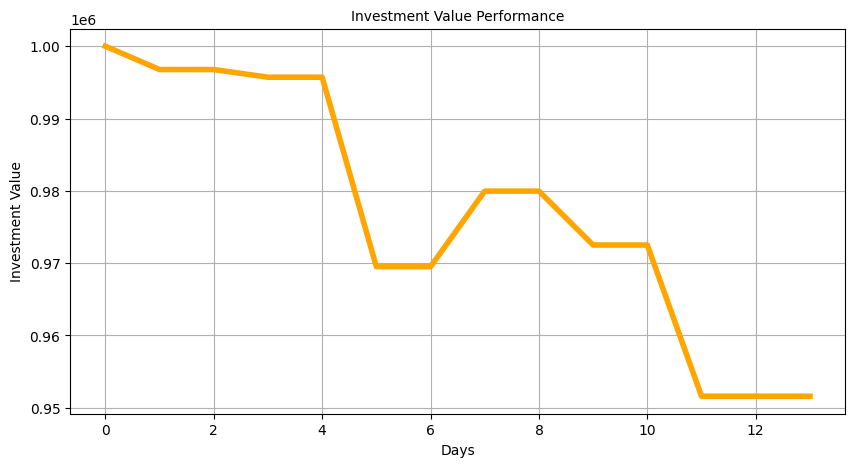

Test Episode 22: Test Reward = 684.21: ROI = -4.84%


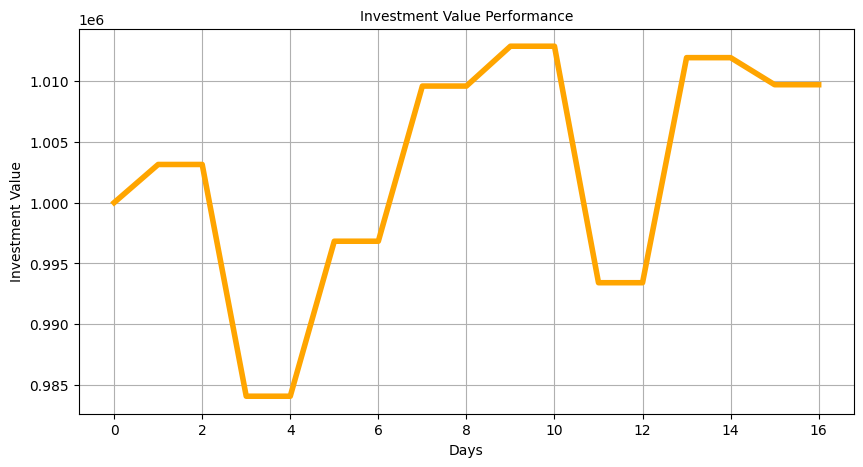

Test Episode 23: Test Reward = 779.87: ROI = 0.97%


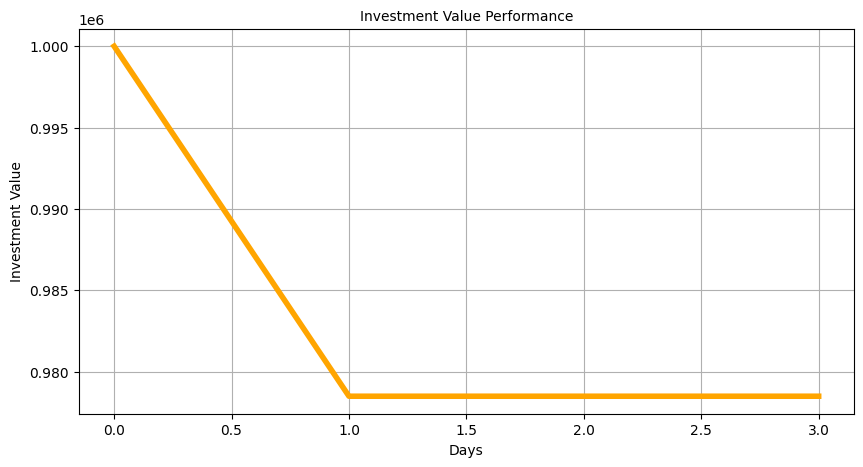

Test Episode 24: Test Reward = 165.99: ROI = -2.15%


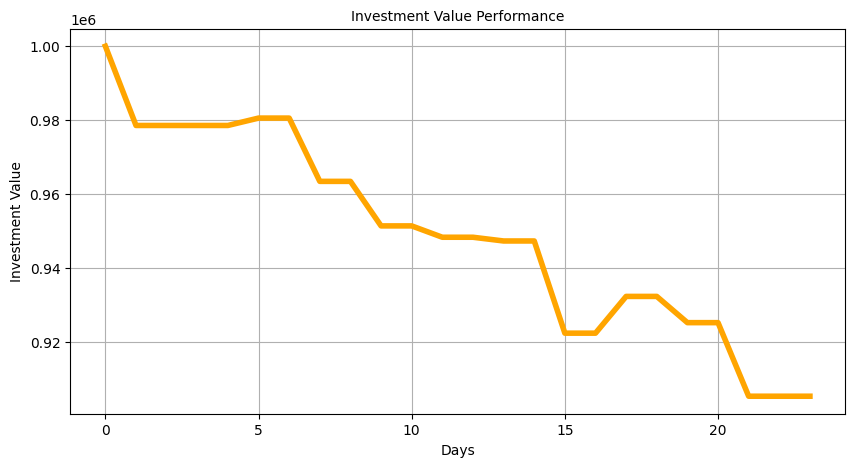

Test Episode 25: Test Reward = 1199.49: ROI = -9.46%


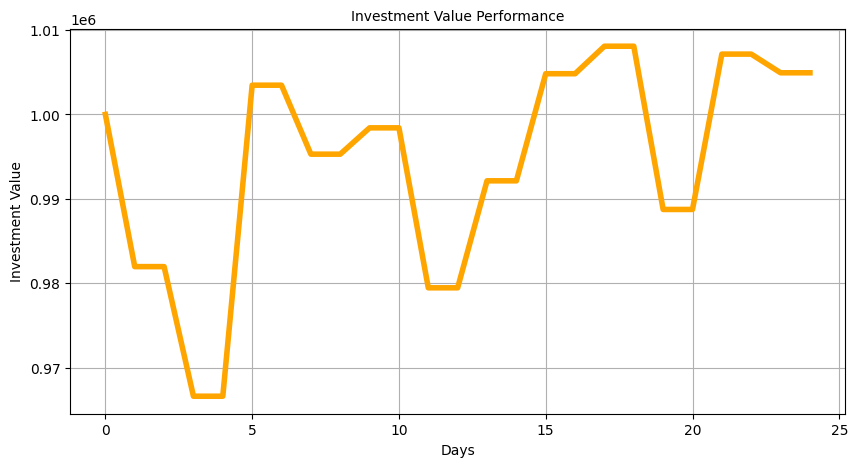

Test Episode 26: Test Reward = 1204.45: ROI = 0.49%


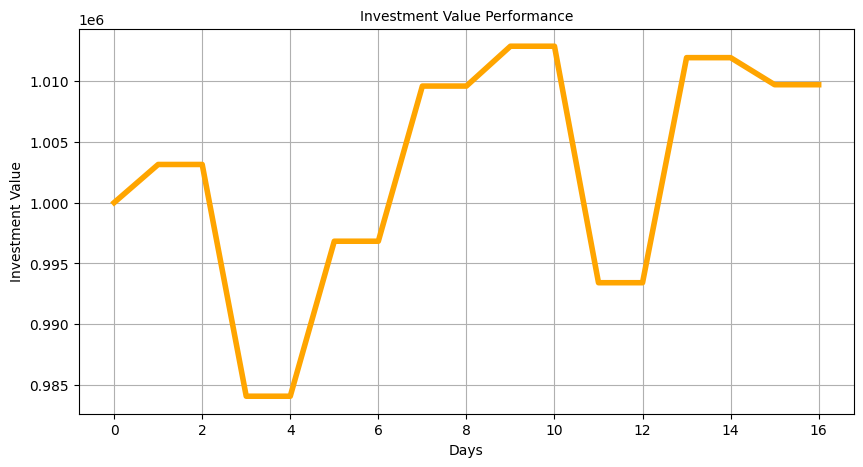

Test Episode 27: Test Reward = 779.87: ROI = 0.97%


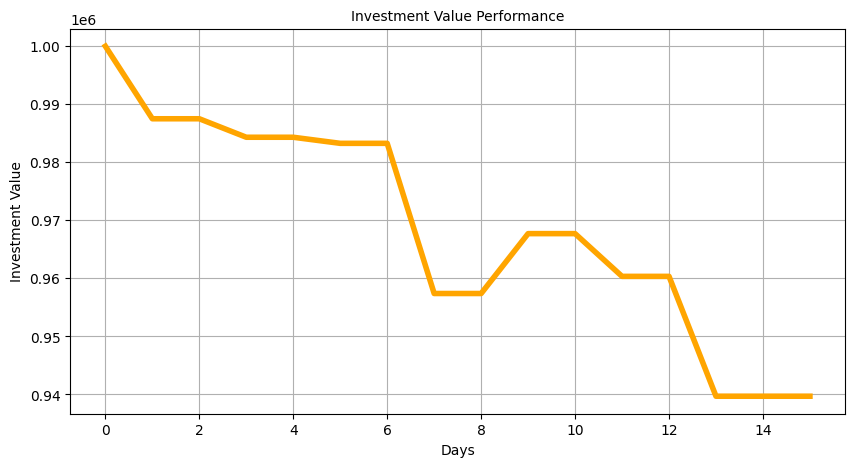

Test Episode 28: Test Reward = 781.25: ROI = -6.03%


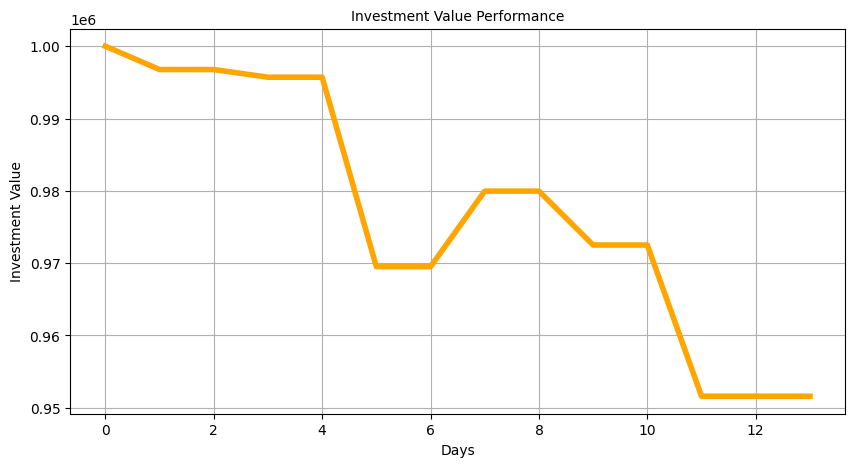

Test Episode 29: Test Reward = 684.21: ROI = -4.84%


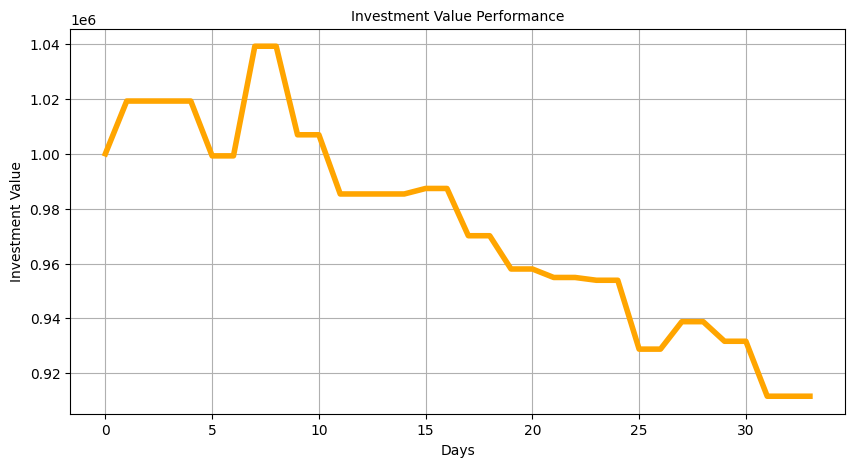

Test Episode 30: Test Reward = 1658.62: ROI = -8.84%


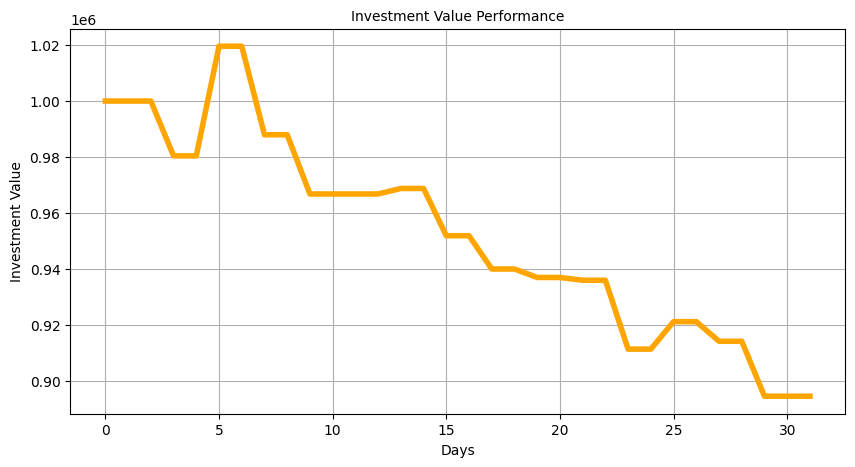

Test Episode 31: Test Reward = 1574.93: ROI = -10.56%


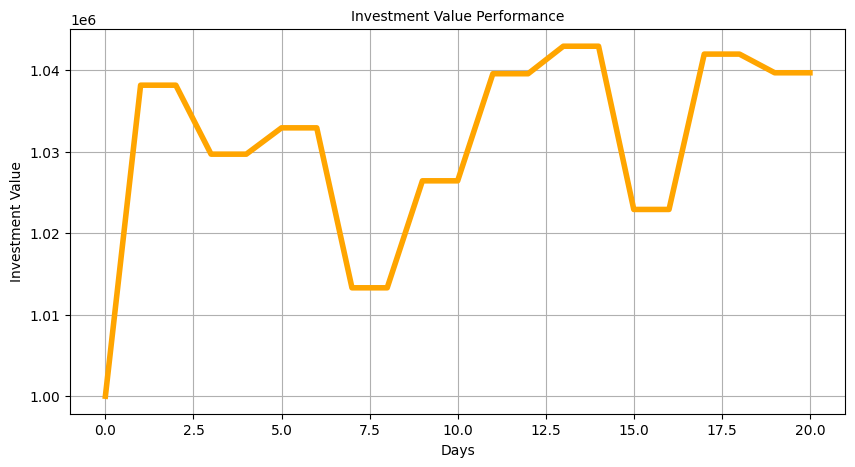

Test Episode 32: Test Reward = 994.70: ROI = 3.97%


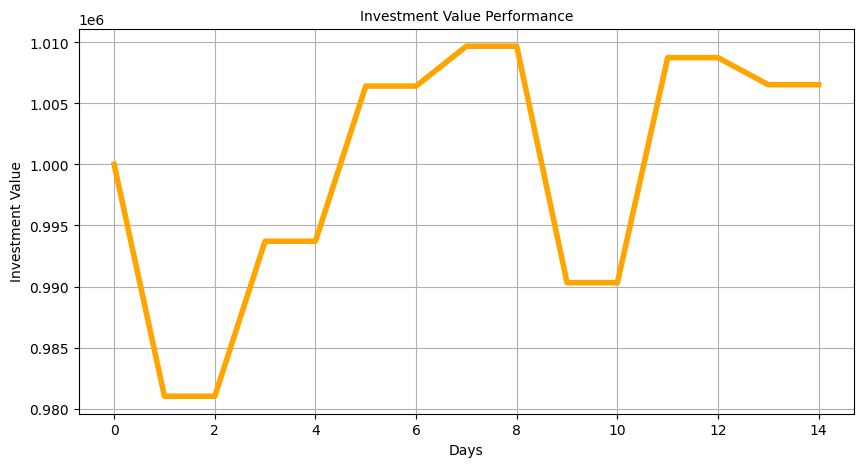

Test Episode 33: Test Reward = 682.43: ROI = 0.65%


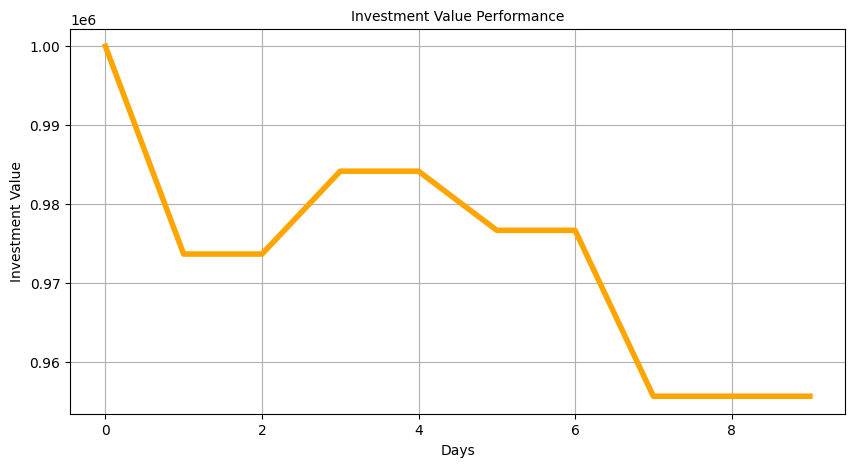

Test Episode 34: Test Reward = 478.04: ROI = -4.43%


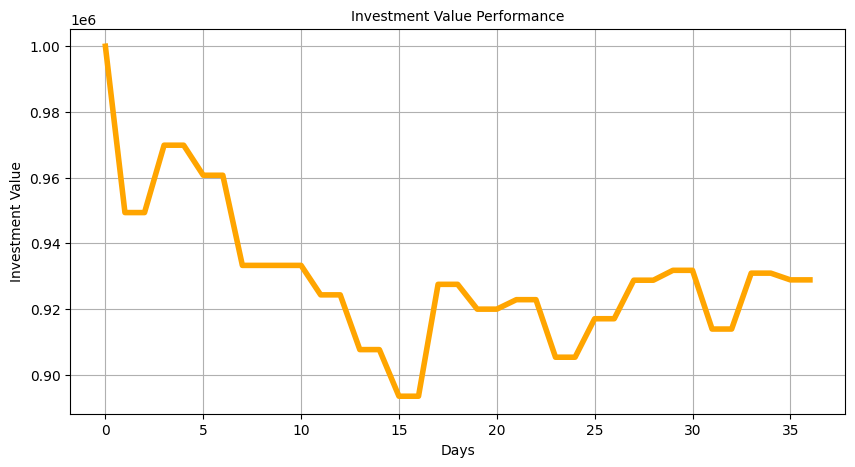

Test Episode 35: Test Reward = 1722.39: ROI = -7.11%


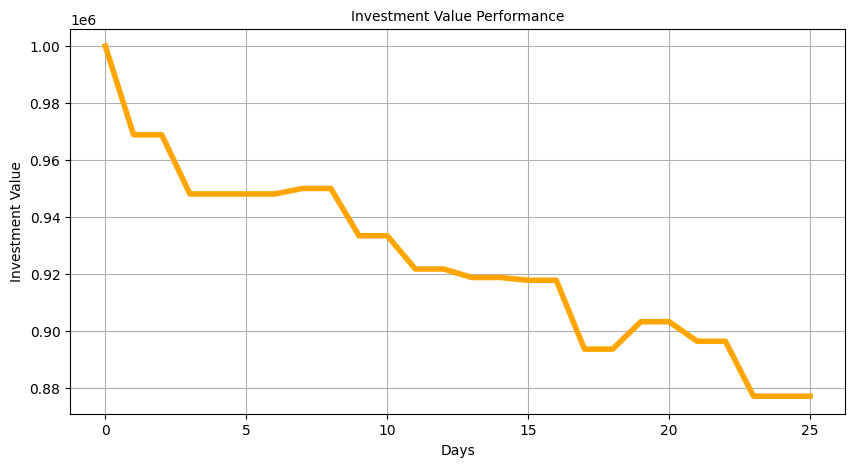

Test Episode 36: Test Reward = 1294.56: ROI = -12.28%


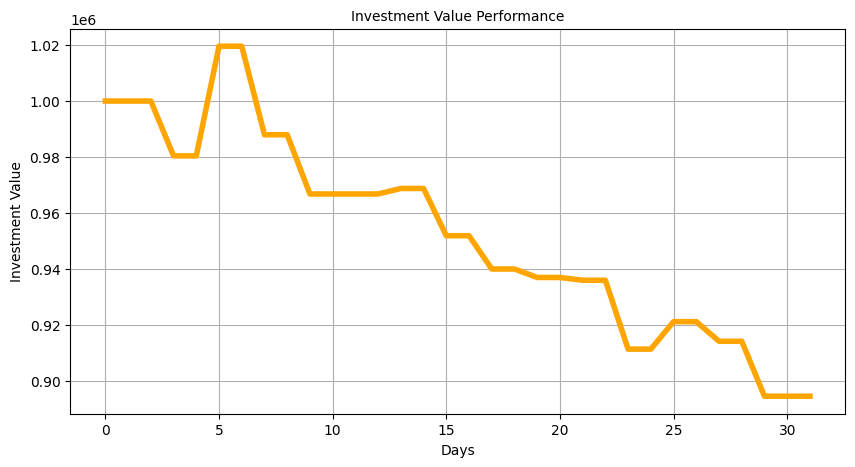

Test Episode 37: Test Reward = 1574.93: ROI = -10.56%


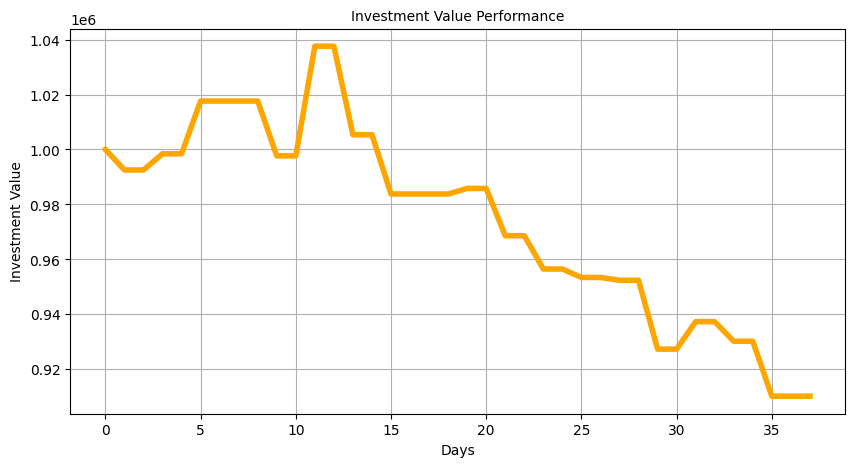

Test Episode 38: Test Reward = 1822.79: ROI = -8.98%


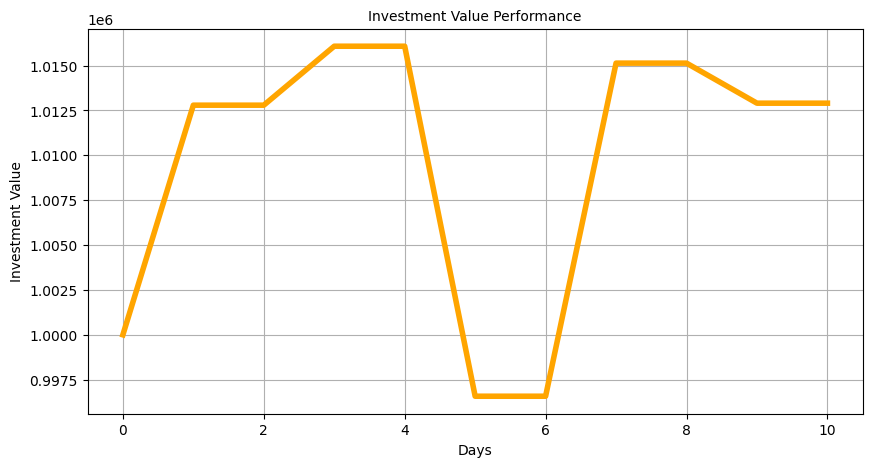

Test Episode 39: Test Reward = 478.23: ROI = 1.29%


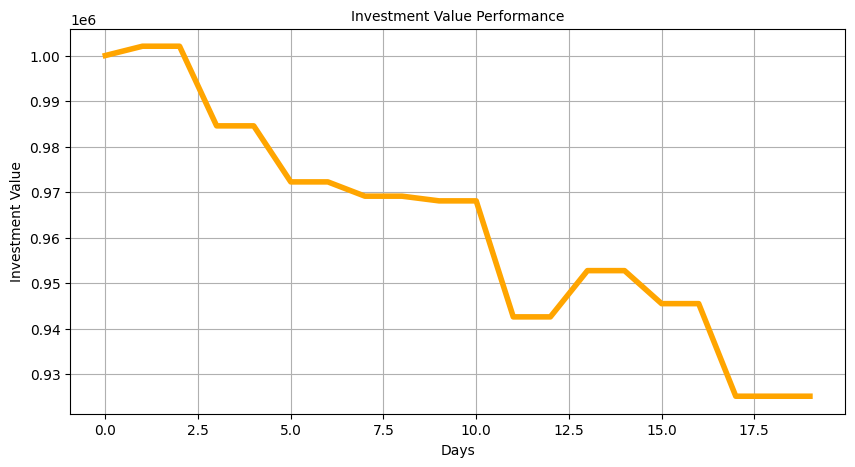

Test Episode 40: Test Reward = 984.64: ROI = -7.48%


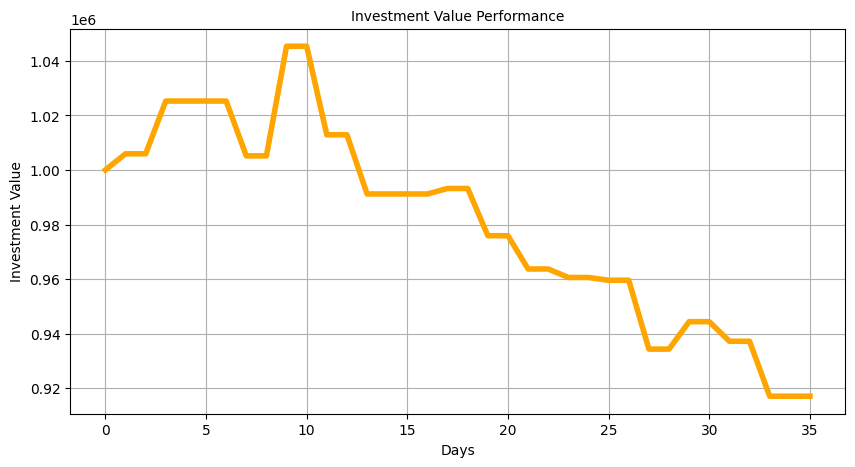

Test Episode 41: Test Reward = 1742.92: ROI = -8.30%


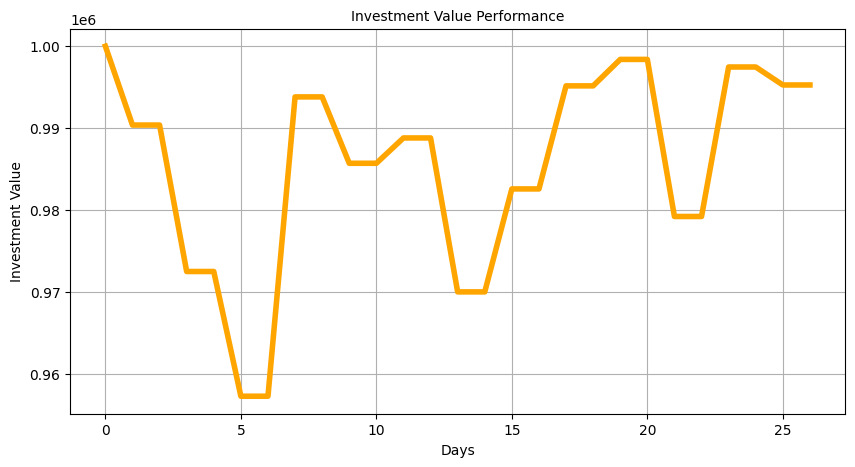

Test Episode 42: Test Reward = 1297.75: ROI = -0.47%


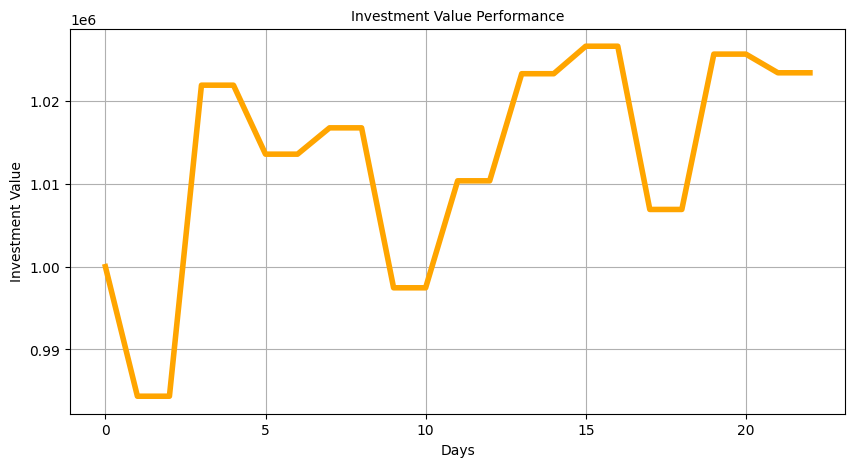

Test Episode 43: Test Reward = 1104.25: ROI = 2.34%


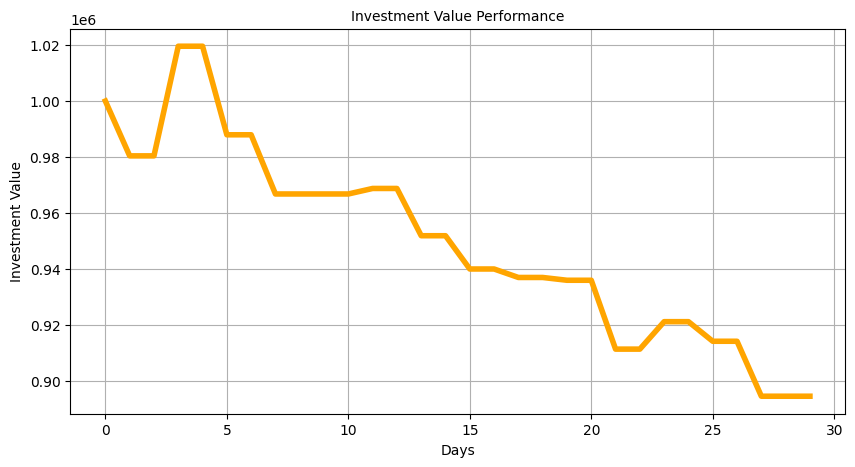

Test Episode 44: Test Reward = 1487.83: ROI = -10.56%


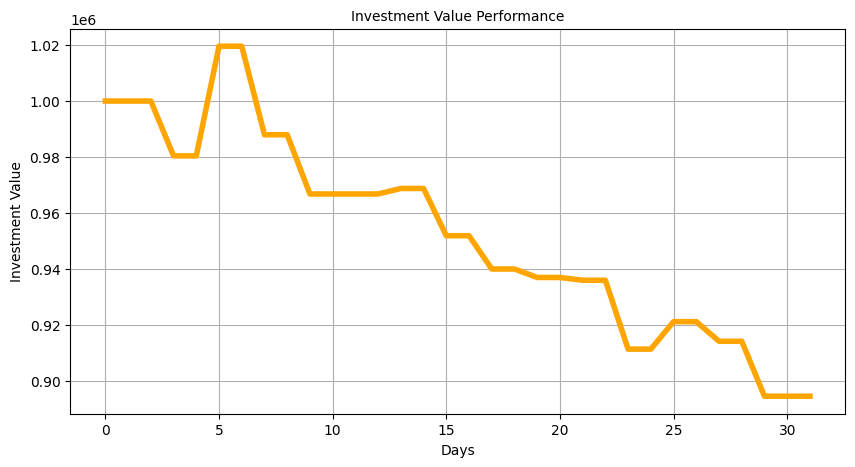

Test Episode 45: Test Reward = 1574.93: ROI = -10.56%


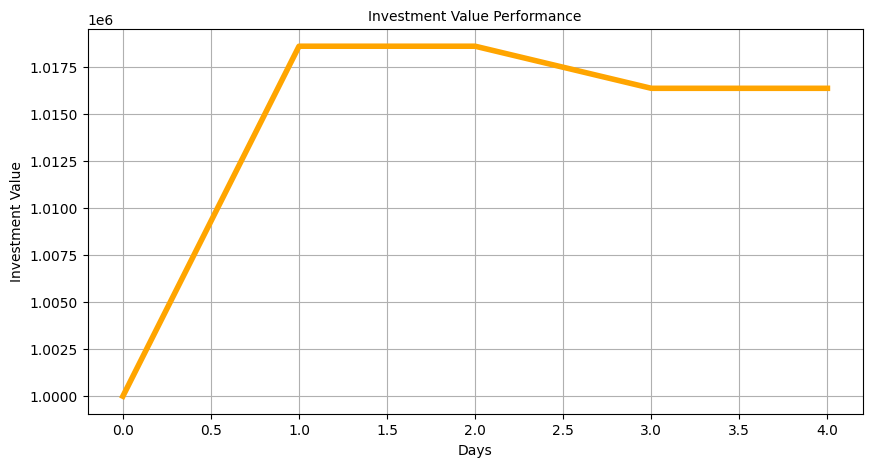

Test Episode 46: Test Reward = 174.14: ROI = 1.64%


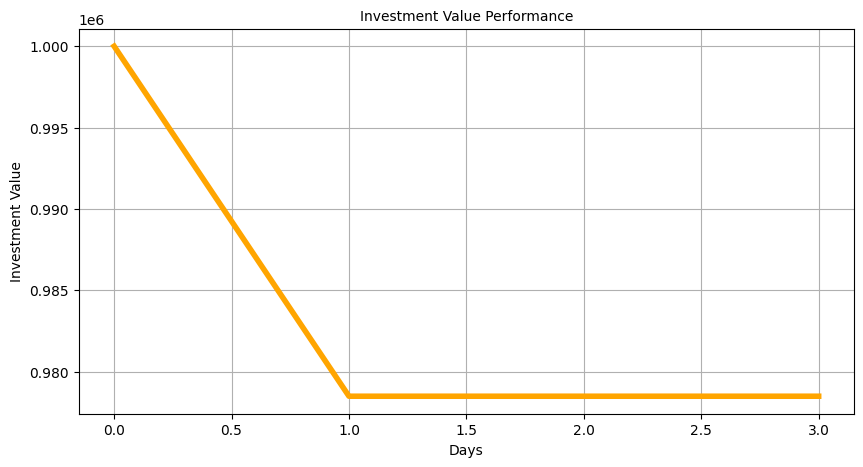

Test Episode 47: Test Reward = 165.99: ROI = -2.15%


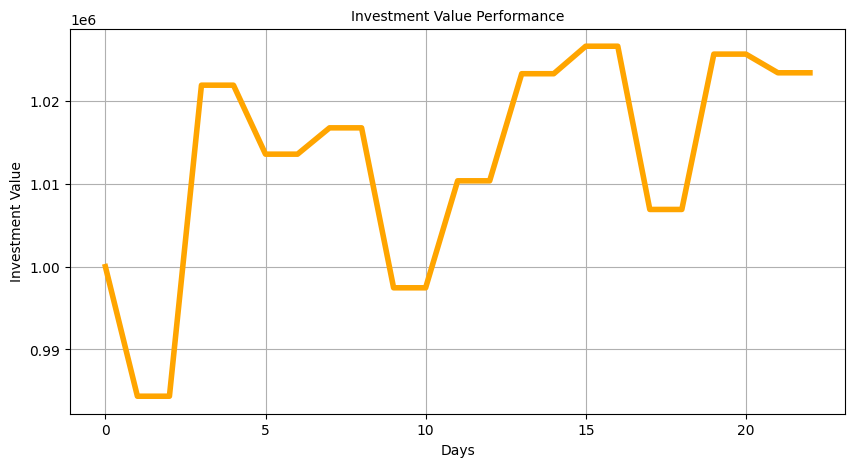

Test Episode 48: Test Reward = 1104.25: ROI = 2.34%


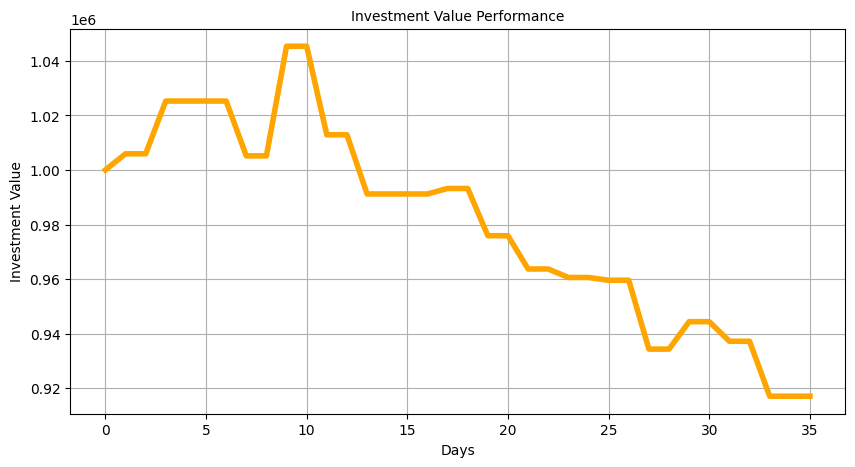

Test Episode 49: Test Reward = 1742.92: ROI = -8.30%


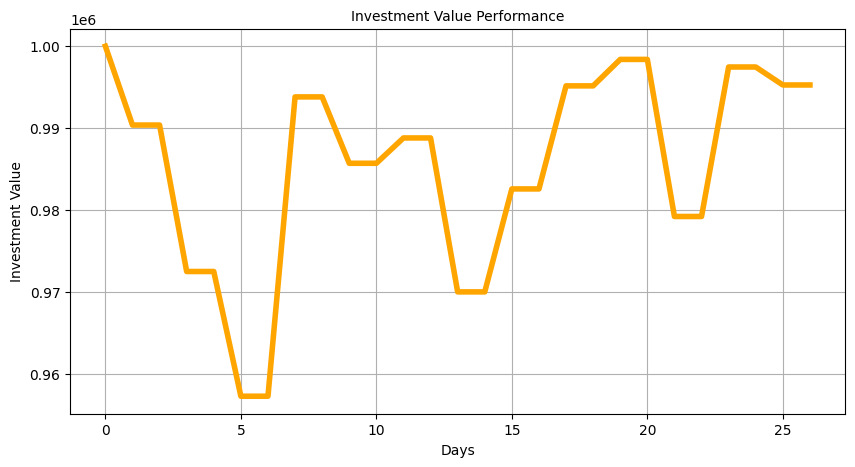

Test Episode 50: Test Reward = 1297.75: ROI = -0.47%


In [12]:
test_env = NGXTrading(sp_history='/content/gtco.csv', train=False, days=30)

test_returns = test_agent(test_env, gtco_agent, episodes=50)

### ....summarizing agent's ROI performance over 30 days trading period

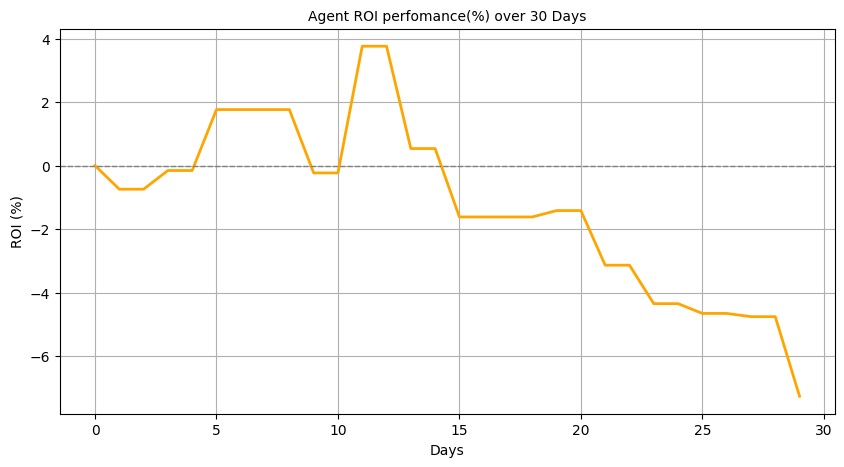

In [21]:
def roi_performance(env, agent, days=30):
    observation, info = env.reset()
    initial_capital = env.capital
    roi_list = []
    investment_list = []
    actions_list = []

    for z in range(days):
        state = int(observation)
        action = np.argmax(agent.Q_table[state])
        observation, reward, terminated, truncated, info = env.step(action)

        current_investment = env.investment
        roi = ((current_investment - initial_capital) / initial_capital) * 100

        roi_list.append(roi)
        investment_list.append(current_investment)
        actions_list.append(action)

        if terminated:
            break

    result = {"roi_list": roi_list}


    plt.figure(figsize=(10, 5))
    plt.plot(range(len(roi_list)), roi_list, color='orange', linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Agent ROI perfomance(%) over 30 Days", fontsize=10)
    plt.xlabel("Days", fontsize=10)
    plt.ylabel("ROI (%)", fontsize=10)
    plt.grid(True)
    plt.show()

    return result

g_roi = roi_performance(test_env, gtco_agent, days=30)